# KNN
Use K nearest neighbors for our regression problem.

In [1]:

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

from helpers import plot_variable_importance, write_metrics_in_csv, plot_ypred_vs_yreal, learning_curve_plot

In [2]:
# Open dataset
filename: str = '../dataRead_processed.pkl.bz2'
dataset: pd.DataFrame = pd.read_pickle(filename, compression='bz2')

FileNotFoundError: [Errno 2] No such file or directory: 'dataRead_processed.pkl.bz2'

In [ ]:
# Last preprocessing steps

# Drop columns that are not needed
dataset = dataset.drop(columns=[
    'city_attraction_area',
    ])

# Split dataset
X = dataset.drop(columns=['total_passengers_2022'])
y = dataset['total_passengers_2022']

# Last preprocessing steps
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

print(cat_features)

# Prepare the final preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

Index(['drg_segment', 'city_size_category', 'Dubious', 'population_category',
       'high_population'],
      dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Simple KNN model

,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,KNN,None,2.718812e+11,140778.833741,33152.0,0.834915


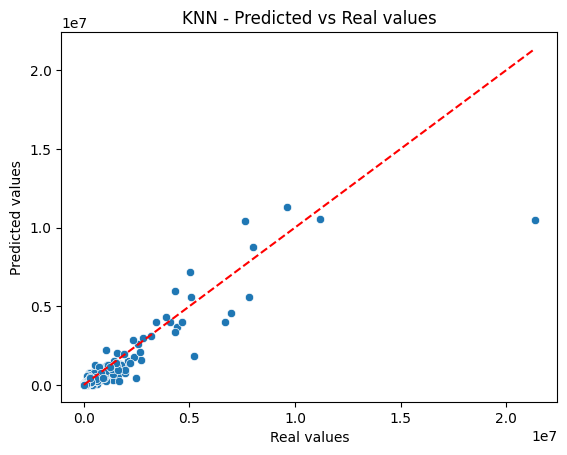

In [ ]:
# Simple KNN model
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

plot_ypred_vs_yreal(y_pred, y_test, 'KNN', False, True)

write_metrics_in_csv(y_pred, y_test, 'KNN')

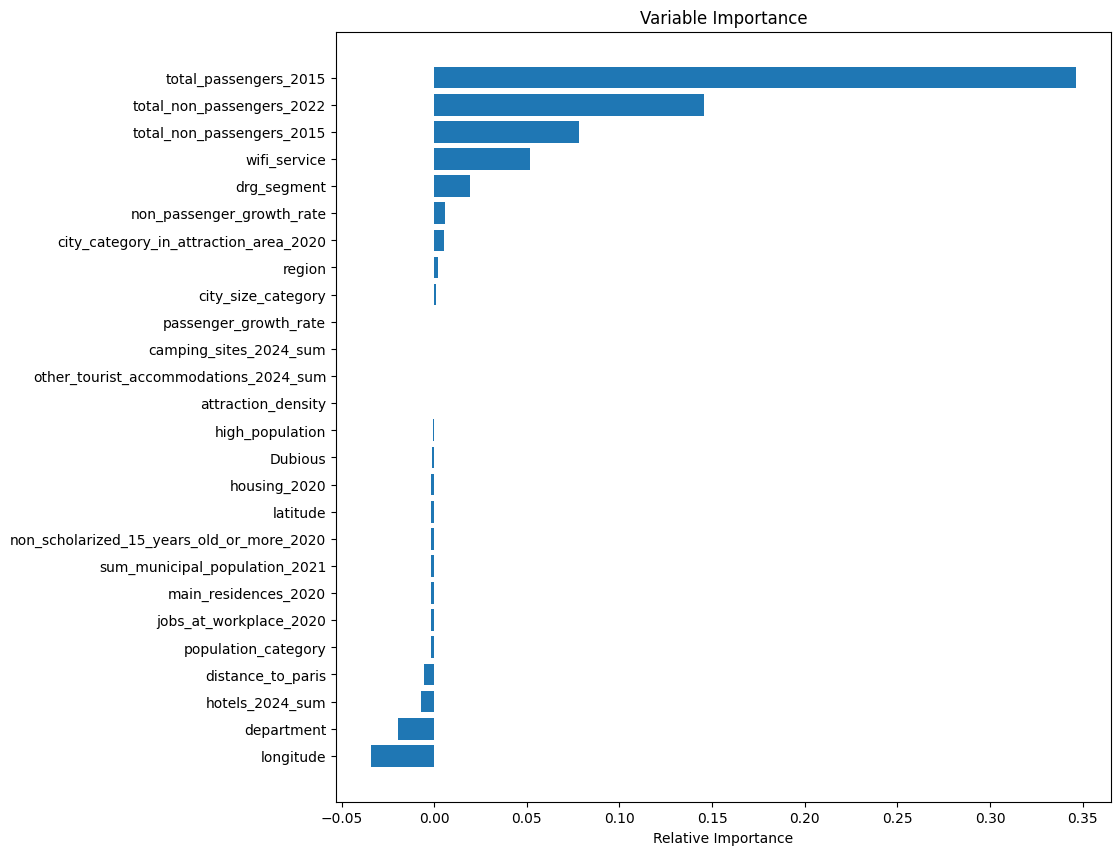

In [ ]:
plot_variable_importance(knn, X_test, y_test)

## Parameter tuning: $k$ of k-nearest neighbors

In [ ]:
# More complex model
train_score = {}
test_score = {}
n_neighbors = np.arange(1, 50, 1)

for neighbor in n_neighbors:
    knn = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('regressor', KNeighborsRegressor(n_neighbors=neighbor))
            ])
    knn.fit(X_train, y_train)
    train_score[neighbor]=knn.score(X_train, y_train)
    test_score[neighbor]=knn.score(X_test, y_test)

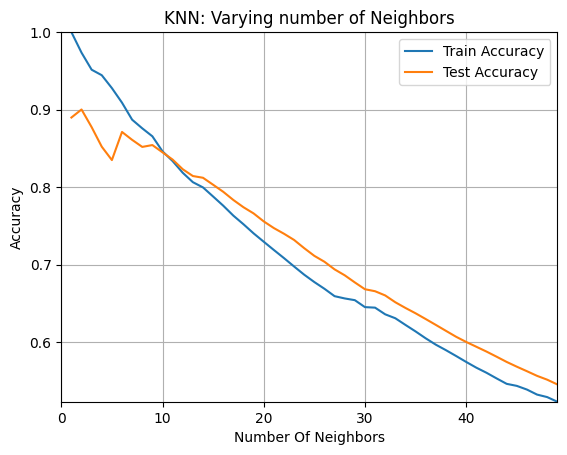

In [ ]:
plt.plot(n_neighbors, train_score.values(), label="Train Accuracy")
plt.plot(n_neighbors, test_score.values(), label="Test Accuracy")
plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors")
plt.legend()
plt.xlim(0, max(n_neighbors))
plt.ylim(min(train_score.values()), max(train_score.values()))
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

# Parameter tuning
kf = KFold(n_splits=20, shuffle=True, random_state=42)
parameter = {'regressor__n_neighbors': np.arange(2, 30, 1)}

knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

knn_cv = GridSearchCV(knn, param_grid=parameter, cv=kf, verbose=1)
knn_cv.fit(X_train, y_train)

Fitting 20 folds for each of 28 candidates, totalling 560 fits


GridSearchCV(cv=KFold(n_splits=20, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['total_passengers_2015', 'wifi_service',
       'city_category_in_attraction_area_2020', 'department', 'region',
       'sum_municipal_population_2021',
       'non_scholarized_15_years_old_or_more_2020', 'mai...
       'non_passenger_growth_rate', 'distance_to_paris'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['drg_segment', 'city_size_category', 'Dubious', 'population_category',
       'high_population'],
      dtype='object'))])),
                                       ('regressor', KNeighborsRegressor())]),
             param_grid={'regressor__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             verbose=1)

,Model,Hyperparameters,Mean Squared Error,Mean Absolute Error,Median Absolute Error,R2 Score
0,KNN_tuned,{'best_k': 4},2.434982e+11,137517.019048,32605.75,0.852149


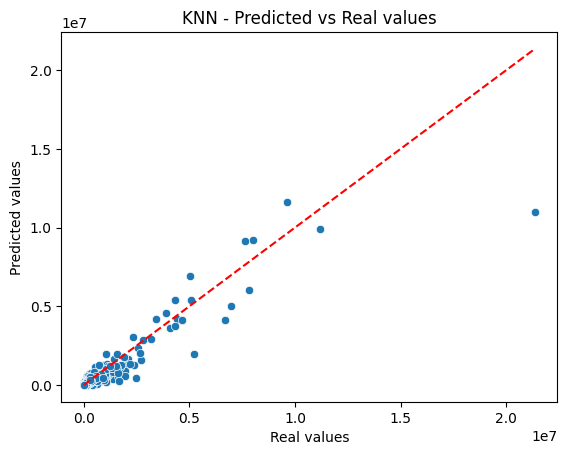

In [ ]:
from sklearn.metrics import accuracy_score

# Get the best hyperparameter
best_k = knn_cv.best_params_['regressor__n_neighbors']

# Use the best hyperparameter and train the final model
knn_cv = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=best_k))
])
knn_cv.fit(X_train, y_train)

# Predict the test set
y_pred = knn_cv.predict(X_test)

plot_ypred_vs_yreal(y_pred, y_test, 'KNN', False, True)
write_metrics_in_csv(y_pred, y_test, 'KNN_tuned', {'best_k':best_k})

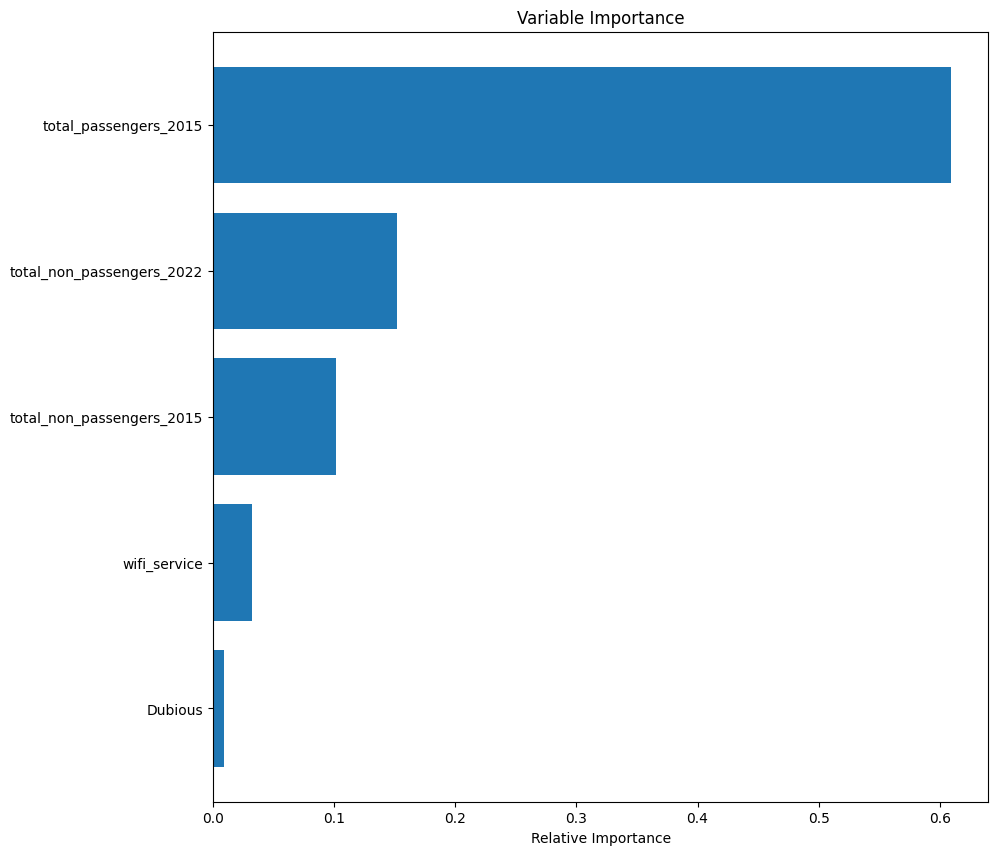

In [ ]:
plot_variable_importance(knn_cv, X_train, y_train, 5)

### Learning curve to detect overfitting

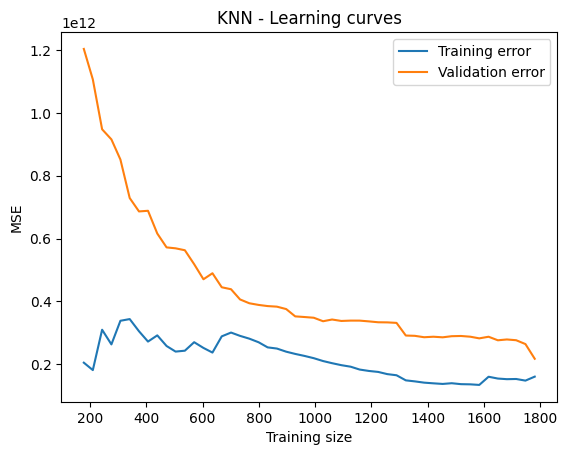

In [ ]:
learning_curve_plot(knn, 'KNN', X, y, 50)

The difference between the training and validation scores is small, so we can say that the model is not overfitting.